# CNN_LSTM Model Pipeline

In [2]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from TrainValTensorBoard import TrainValTensorBoard
from scipy import signal
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [3]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [4]:
tf.__version__

'1.13.1'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [5]:
df = pd.read_csv('/nfs/2018/j/jcruz-y-/neurotron_datasets/joined/joined_data_106979_24-Oct-19_17:31_jose_all_1.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [6]:
df.head()

,Leap timestamp,timestamp diff,emg timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
0,1.571891e+09,0.006226,1.571891e+09,50.0,250.0,396.0,89.0,53.0,43.0,31.0,61.0,9.262085,-9.118690,47.617905,-18.114399,-8.678528,51.673462,-46.709621,-12.567474,17.094170,-69.877258,-11.163055,-3.096992,-85.138763,-10.990265,-17.690151,-20.603283,15.033867,-19.298096,-18.594982,29.675285,-55.134228,-23.628544,21.952751,-74.898529,-29.280987,9.089638,-81.241966,-1.600807,9.199806,-21.184177,9.602978,22.597313,-61.013245,5.366776,12.613152,-84.265617,-2.429310,-1.073235,-90.542023,16.659401,0.454193,-17.607121,31.992260,15.967636,-51.509766,30.006121,9.053932,-75.447060,22.099865,-3.387665,-83.625824,31.320591,-11.242180,-12.971455,48.320904,0.762253,-37.152554,49.054413,-1.940414,-54.576313,42.004250,-10.960121,-65.103134
1,1.571891e+09,-0.029152,1.571891e+09,50.0,286.0,368.0,74.0,51.0,29.0,23.0,42.0,6.786233,-11.333852,47.534789,-20.769446,-11.812599,49.990927,-48.818829,-12.573416,14.808353,-71.526649,-9.472275,-5.685904,-86.040143,-8.497499,-20.978106,-19.892583,15.473871,-19.684725,-16.363919,31.977931,-54.562784,-20.061439,25.205292,-74.945980,-24.964155,12.585976,-82.297033,-0.656441,10.240284,-20.741277,12.169991,25.430847,-59.404511,9.774177,16.861857,-83.445555,3.000662,3.609998,-91.510464,17.612489,1.798022,-16.543760,34.630843,19.197273,-48.656146,34.708936,13.781877,-73.032392,28.021311,1.851053,-82.843496,32.317179,-9.737174,-11.650706,50.569850,3.507205,-34.192403,52.642263,1.569894,-51.594506,46.731619,-7.074512,-63.067226
2,1.571891e+09,0.001225,1.571891e+09,48.0,270.0,347.0,69.0,50.0,29.0,22.0,37.0,5.317806,-12.499672,47.453987,-22.304150,-13.473961,48.934364,-50.567093,-11.620216,13.915695,-73.125786,-7.157860,-6.519272,-87.022034,-5.696548,-22.351597,-19.449600,15.688126,-19.963085,-15.181034,33.082428,-54.341133,-18.064960,27.075287,-75.106461,-22.477337,14.810486,-83.337776,-0.101135,10.783897,-20.485744,13.475960,26.486450,-58.701767,12.304794,18.931656,-83.193710,6.364304,6.209526,-92.698830,18.149715,2.515739,-15.874870,36.093548,20.546936,-47.148628,37.534588,16.020477,-71.687836,31.792110,4.564583,-82.641403,32.863037,-8.918983,-10.774841,52.029774,4.644127,-32.373928,55.188416,3.101257,-49.667633,50.315052,-5.215370,-61.872467
3,1.571891e+09,0.009088,1.571891e+09,49.0,245.0,326.0,66.0,39.0,28.0,23.0,36.0,5.141285,-12.493469,47.475067,-22.483795,-13.559532,48.828407,-50.828781,-11.390457,13.894257,-73.361900,-6.804001,-6.541451,-87.106232,-5.372879,-22.508564,-19.409599,15.628494,-20.048607,-15.110043,33.002945,-54.432831,-17.841034,27.203735,-75.277794,-22.137730,15.102798,-83.807457,-0.042805,10.788460,-20.483543,13.552137,26.346481,-58.752304,12.602261,18.943726,-83.300186,6.865059,6.356377,-93.104897,18.213963,2.579636,-15.790806,36.240501,20.540024,-47.057739,37.922184,16.111511,-71.599510,32.396820,4.750542,-82.761627,32.941494,-8.807564,-10.625877,52.218910,4.702339,-32.159714,55.573746,3.183128,-49.418533,50.933563,-5.084938,-61.746620
4,1

In [7]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)

In [8]:
df = df[:5000]
df.shape

(5000, 71)

In [9]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,109.102400,199.677800,286.003200,135.899200,55.258200,51.769400,74.662600,67.408000,-5.198813,-4.246083,49.331277,-30.954265,-12.171475,43.779154,-33.136000,-27.828879,2.232312,-34.050009,-38.630949,-25.679954,-33.266757,-46.313609,-43.933759,-16.147558,6.953186,-27.217459,-9.839613,4.582677,-62.449130,-7.468645,-3.910228,-78.402134,-6.615928,-12.163438,-86.350045,3.037245,7.395347,-21.761870,16.219966,3.364677,-59.527298,20.624587,-7.191090,-77.584082,21.739136,-16.544398,-86.085147,20.573374,5.078548,-11.017020,32.790314,-2.546990,-45.122998,36.491999,-14.423493,-62.642792,36.960269,-24.823603,-71.564043,35.428416,-1.032715,-0.111580,47.617296,-8.150331,-26.029792,50.290362,-17.045287,-38.509005,49.950458,-26.994540,-47.183958
std,173.018963,138.596875,192.954632,105.992267,43.090116,82.997964,102.766254,119.905831,7.825778,12.190646,3.788470,9.800771,15.679564,6.693409,11.071813,11.329830,8.770653,17.970047,12.536696,11.399894,23.877210,14.451606,13.516239,4.981293,7.309155,2.614449,9.796797,21.186227,6.538009,12.201428,30.338838,13.164475,14.133833,35.794664,20.373427,4.593345,5.510408,2.370834,11.057274,21.757272,7.659924,17.158616,32.237881,14.072279,21.998403,37.982428,20.781485,3.825444,7.407345,3.480968,11.088655,19.102271,9.238345,18.338105,27.336048,15.629497,23.663257,31.927795,21.444579,3.772627,11.050847,4.768862,10.740999,16.127557,8.768980,17.135544,19.597015,12.049278,22.886125,22.102120,16.090146
min,19.000000,20.000000,23.000000,26.000000,20.000000,17.000000,16.000000,17.000000,-28.459534,-36.025116,12.642181,-51.847256,-50.313751,7.371819,-67.971062,-62.493591,-32.309222,-90.193291,-85.025411,-58.903809,-102.430875,-103.504150,-80.039200,-31.425241,-31.792175,-31.811234,-42.302876,-67.396919,-73.383875,-50.308414,-85.256256,-96.546054,-55.500813,-100.575760,-112.462585,-16.552727,-20.359009,-25.657837,-25.828159,-63.445162,-72.724304,-41.345818,-88.000181,-98.275253,-53.070572,-104.996796,-115.310730,-6.564236,-15.865082,-23.457855,-7.488388,-50.211551,-63.275589,-24.174629,-75.105942,-87.228676,-38.265263,-91.151232,-104.522316,6.307455,-35.751801,

### Raw labels and features

In [10]:
#feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values
label_tips = label_ar[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
print(label_ar.shape)
print(label_tips.shape)

(5000, 63)
(5000, 18)


spec_shape: (7, 13)
frequencies_shape: (7,)
times_shape: (13,)


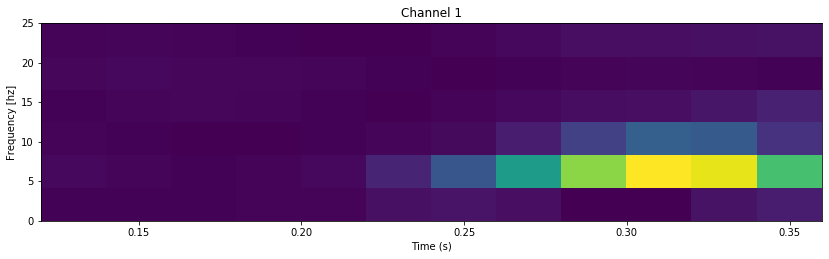

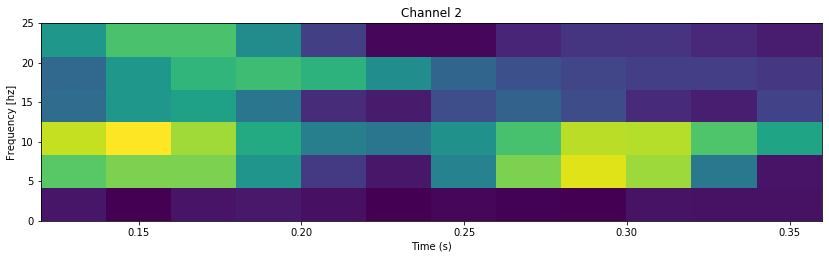

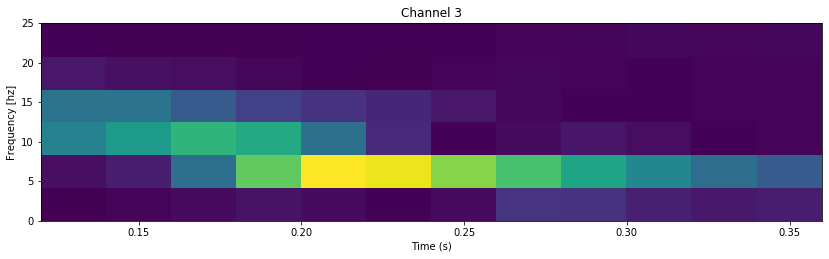

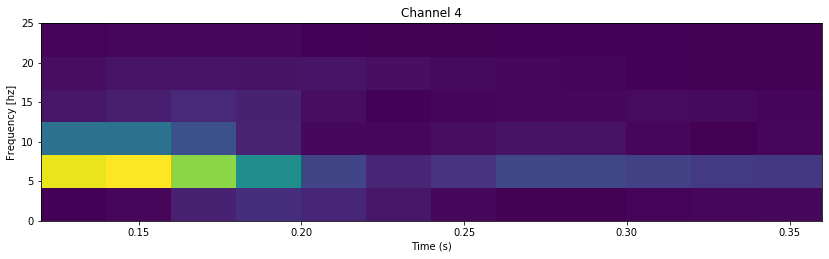

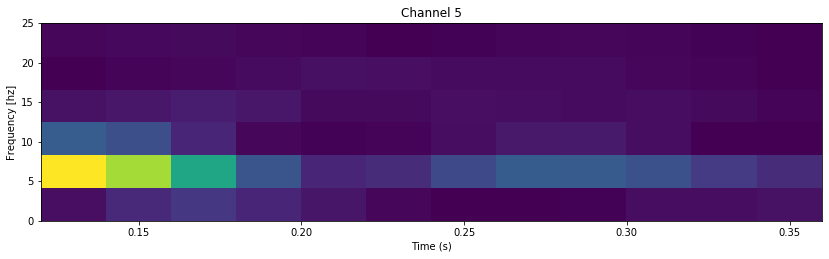

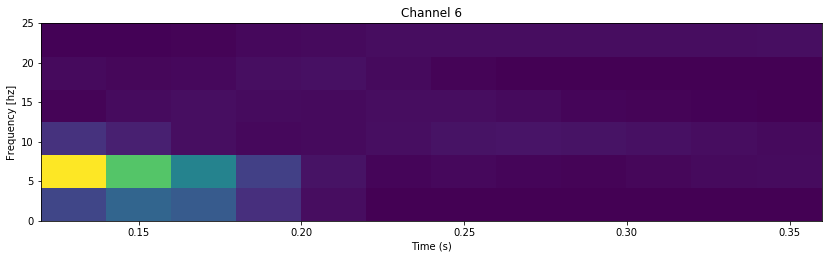

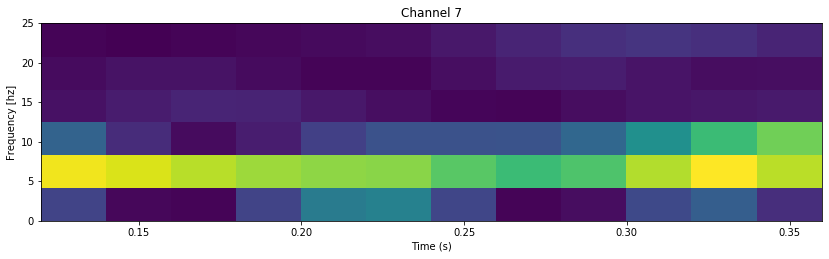

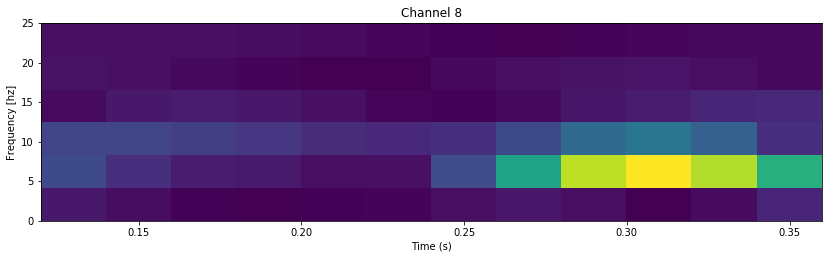

In [11]:
#Spectrogram hyperparameters
nperseg=12 #increasing nperseg increases frequency resolution and decreases time res
noverlap=11 #increasing time resolution requires increasing overlap
window = 'hann' #hann provides good time and frequency resolution properties

#Spectrogram
frequencies, times, spec = signal.spectrogram(x=df['ch1'][24:48],
                                              fs=50, nperseg=nperseg,
                                              noverlap=noverlap, window=window)
#Subplot 1
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.title('Channel 1')
ax1 = plt.ylabel('Frequency [hz]')
ax1 = plt.xlabel('Time (s)')
ax1 = plt.show

#Subplot 2
frequencies, times, spec = signal.spectrogram(x=df['ch2'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.title('Channel 2')
ax1 = plt.ylabel('Frequency [hz]')
ax1 = plt.xlabel('Time (s)')
ax1 = plt.show

#Subplot 3
frequencies, times, spec = signal.spectrogram(x=df['ch3'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.title('Channel 3')
ax1 = plt.ylabel('Frequency [hz]')
ax1 = plt.xlabel('Time (s)')
ax1 = plt.show

#Subplot 4
frequencies, times, spec = signal.spectrogram(x=df['ch4'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.title('Channel 4')
ax1 = plt.ylabel('Frequency [hz]')
ax1 = plt.xlabel('Time (s)')
ax1 = plt.show

#Subplot 5
frequencies, times, spec = signal.spectrogram(x=df['ch5'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.title('Channel 5')
ax1 = plt.ylabel('Frequency [hz]')
ax1 = plt.xlabel('Time (s)')
ax1 = plt.show

#Subplot 6
frequencies, times, spec = signal.spectrogram(x=df['ch6'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.title('Channel 6')
ax1 = plt.ylabel('Frequency [hz]')
ax1 = plt.xlabel('Time (s)')
ax1 = plt.show

#Subplot 7
frequencies, times, spec = signal.spectrogram(x=df['ch7'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.title('Channel 7')
ax1 = plt.ylabel('Frequency [hz]')
ax1 = plt.xlabel('Time (s)')
ax1 = plt.show

#Subplot 8
frequencies, times, spec = signal.spectrogram(x=df['ch8'][24:48], fs=50, nperseg=nperseg, noverlap=noverlap, window=window)
log_spec = np.log(spec)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1 = plt.pcolormesh(times, frequencies, spec)
ax1 = plt.title('Channel 8')
ax1 = plt.ylabel('Frequency [hz]')
ax1 = plt.xlabel('Time (s)')
ax1 = plt.show


#Specs and Shapes
#print('label:', label_dir)
#print('file:', file)
print('spec_shape:', spec.shape)
print('frequencies_shape:', frequencies.shape)
print('times_shape:', times.shape)

### Making Spectograms


In [12]:
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8']
shape = (7, 13, 8)
flat_dim = shape[0]*shape[1]*shape[2]
nperseg = 12
noverlap = 11
reshape = (-1, shape[0], shape[1], shape[2])
j = 1
i = 0
dir_num = 0
df_train_g = pd.DataFrame()

img = np.zeros(shape)
k = 0
num_samples = len(df)
x_shape = (num_samples, 7, 13, 8)
x1_train = np.zeros(x_shape)

for i in range(len(df) - 24):
    for j in range(8):
        frequencies, times, spec = signal.spectrogram(x=df[channels[j]][k:k+24], fs=50,
                                                  nperseg=nperseg, noverlap=noverlap,
                                                  window='hann')
        log_spec = np.log(spec)
        img[:,:,j] = spec
        j = j + 1
    x1_train[i,:,:,:] = img
    i = i + 1
    k = k + 1
    if i == 4457:
        print(df.iloc[i,:])
    if i % 10000 == 0:
        print(i)
print(x1_train.shape)
flat = np.reshape(x1_train, (num_samples, flat_dim))
df_train1 = pd.DataFrame(data=flat)
df_train_g = df_train_g.append(df_train1, ignore_index=True)

/nfs/2018/j/jcruz-y-/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


ch1                      77.000000
ch2                     317.000000
ch3                     736.000000
ch4                      92.000000
ch5                      55.000000
ch6                      50.000000
ch7                      59.000000
ch8                     223.000000
Wrist x                  -6.398444
Wrist y                   5.941345
Wrist z                  50.947983
Thumb Proximal x        -34.240585
Thumb Proximal y         -1.015900
Thumb Proximal z         46.875137
Thumb Intermediate x    -45.404907
Thumb Intermediate y    -24.153854
Thumb Intermediate z      7.319672
Thumb Distal x          -56.139301
Thumb Distal y          -38.200821
Thumb Distal z          -19.612495
Thumb Tip x             -62.811890
Thumb Tip y             -48.254807
Thumb Tip z             -38.143677
Index Proximal x        -15.970114
Index Proximal y          3.412628
Index Proximal z        -29.242577
Index Intermediate x     -8.280552
Index Intermediate y     17.498474
Index Intermediate z

## Preprocess features and get labels
Reshaping
Handling overflow (inf) and underflow (-inf) <br>


In [13]:
def preprocess_features(x_train):
    shape = (7, 13, 8)
    reshape = (-1, shape[0], shape[1], shape[2])
    x_train = x_train.replace(-np.inf, 0)
    x_train = x_train.replace(np.inf, 0)
    #x_train = np.log(x_train.values)
    x_train = x_train.values
    x_train_norm = x_train.reshape(reshape)
    return x_train_norm

features = preprocess_features(df_train_g)
labels = df.loc[:, 'Wrist x':].values
labels_tips = labels[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]

### Reshaping samples
The target shape corresponds to (sequence_number, frequency_axis, time_axis, input_dim)

In [14]:
seq_length = 24

def reshape_overlap_samples(seq_length, feats, labels):
    samples = feats.shape[0] - (seq_length - 1)    # all samples except the last sequence
    shape = (24, 7, 13, 8)
    new_f = np.zeros(shape=(samples, 24, 7, 13, 8))
    print(new_f.shape)
    new_l = labels[seq_length - 1:]
    queue = collections.deque(feats[:seq_length])
    new_f[0] = np.array(queue)
    j = 1
    for i in range(seq_length, feats.shape[0]):
        queue.popleft()
        queue.append(feats[i])
        new_f[j] = np.array(queue)
        j += 1
    return (new_f, new_l)

features_ol, labels_ol = reshape_overlap_samples(seq_length, features, labels_tips)
print(features_ol.shape)
print(labels_ol.shape)

(4977, 24, 7, 13, 8)
(4977, 24, 7, 13, 8)
(4977, 18)


### CNN_LSTM
Not going too down because of 'relu' activation function

In [32]:
def create_model(input_shape):

    inputlayer = Input(shape=input_shape)
    norm_input = BatchNormalization()(inputlayer)
    model = TimeDistributed(Conv2D(32, kernel_size=2, padding='same', activation='relu'))(norm_input)
    model = Dropout(rate=0.2)(model)
    model = BatchNormalization()(model)
    model = TimeDistributed(Conv2D(32, kernel_size=2, padding='same', activation='relu'))(model)
    model = Dropout(rate=0.2)(model)
    model = BatchNormalization()(model)
    #model = BatchNormalization()(TimeDistributed(Dense(128, activation='relu')(model)))
    model = TimeDistributed(Flatten())(model)
    model = LSTM(64, activation='relu', return_sequences=True)(model)
    model = Dropout(0.2)(model)
    model = BatchNormalization()(model)
    model = LSTM(64, activation='relu', return_sequences=False)(model)
    model = Dropout(0.2)(model)
    model = BatchNormalization()(model)#(Dense(63, activation='relu')(model))
    dense = Dense(18, activation=None)(model)
    model = Model(inputs=inputlayer, outputs=dense)
    #model = Model(inputs, decoder_output, name="model_v1")
    return model

print(shape)
model = create_model((24, 7, 13, 8))

model.summary()

(24, 7, 13, 8)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 7, 13, 8)]    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 24, 7, 13, 8)      32        
_________________________________________________________________
time_distributed_9 (TimeDist (None, 24, 7, 13, 32)     1056      
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 7, 13, 32)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 24, 7, 13, 32)     128       
_________________________________________________________________
time_distributed_10 (TimeDis (None, 24, 7, 13, 32)     4128      
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 7, 1

In [26]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [27]:
model.evaluate(features_ol, labels_ol, verbose=1)

4977/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

446990.0803224128

In [30]:
history = model.fit(features_ol, labels_ol, batch_size=seq_length, epochs=10
                    , verbose=1, validation_split=0.2, shuffle=True)

Train on 3981 samples, validate on 996 samples
Epoch 1/10
3981/3981 [==============================] - 29s 7ms/sample - loss: 422.4906 - val_loss: 311.9832
Epoch 2/10
3981/3981 [==============================] - 29s 7ms/sample - loss: 437.3758 - val_loss: 326.0894
Epoch 3/10
3981/3981 [==============================] - 30s 7ms/sample - loss: 443.1009 - val_loss: 280.0540
Epoch 4/10
3981/3981 [==============================] - 29s 7ms/sample - loss: 435.5993 - val_loss: 283.8537
Epoch 5/10
3981/3981 [==============================] - 29s 7ms/sample - loss: 432.2566 - val_loss: 297.7552
Epoch 6/10
3981/3981 [==============================] - 37s 9ms/sample - loss: 431.0414 - val_loss: 301.8677
Epoch 7/10
3981/3981 [==============================] - 39s 10ms/sample - loss: 427.2439 - val_loss: 291.4190
Epoch 8/10
3981/3981 [==============================] - 35s 9ms/sample - loss: 424.4643 - val_loss: 296.4846
Epoch 9/10
3981/3981 [==============================] - 29s 7ms/sample - loss: 4

### ConvLSTM2D

In [34]:
def create_model(input_shape):
    inputlayer = Input(shape=input_shape)
    
    norm_input = BatchNormalization()(inputlayer)
    model = ConvLSTM2D(16, kernel_size=2, padding='same', activation='relu', return_sequences=True)(norm_input)
    model = Dropout(rate=0.3)(model)
    #model = ConvLSTM2D(16, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    #model = Dropout(rate=0.5)(model)
    #model = ConvLSTM2D(32, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    #model = Dropout(rate=0.5)(model)
    model = ConvLSTM2D(32, kernel_size=2, padding='same', activation='relu', return_sequences=False)(model)
    model = Dropout(rate=0.3)(model)
    #model = ConvLSTM2D(128, kernel_size=2, padding='same', activation='relu', return_sequences=True)(model)
    #model = Dropout(rate=0.5)(model)
    #model = ConvLSTM2D(128, kernel_size=2, padding='same', activation='relu', return_sequences=False)(model)
    #model = Dropout(rate=0.5)(model)
    model = Flatten()(model)
    #mode1 = BatchNormalization()(Dense(128, activation='relu')(model))
    mode1 = BatchNormalization()(Dense(128, activation='relu')(model))
    model = Dense(18, activation=None)(model)
    
    model = Model(inputs=inputlayer, outputs=model)
    #model = Model(inputs, decoder_output, name="model_v1")
    return model

shape = (24, 7, 13, 8)
model = create_model(shape)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 24, 7, 13, 8)]    0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 24, 7, 13, 8)      32        
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 24, 7, 13, 16)     6208      
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 7, 13, 16)     0         
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, 7, 13, 32)         24704     
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 13, 32)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2912)              0   

In [35]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [36]:
model.evaluate(features_ol, labels_ol, verbose=1)

4977/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

505800.1363787092

In [37]:
history = model.fit(features_ol, labels_ol, batch_size=seq_length, epochs=6
                    , verbose=1, validation_split=0.2, shuffle=False)

Train on 3981 samples, validate on 996 samples
Epoch 1/6
3981/3981 [==============================] - 97s 24ms/sample - loss: 13606.0753 - val_loss: 2370.4555
Epoch 2/6
3981/3981 [==============================] - 93s 23ms/sample - loss: 151770.9785 - val_loss: 2371.2936
Epoch 3/6
3981/3981 [==============================] - 101s 25ms/sample - loss: 3219.9044 - val_loss: 2303.9436
Epoch 4/6
3981/3981 [==============================] - 96s 24ms/sample - loss: 2381.8404 - val_loss: 2280.1367
Epoch 5/6
3981/3981 [==============================] - 96s 24ms/sample - loss: 3872.9792 - val_loss: 3506.5822
Epoch 6/6
3981/3981 [==============================] - 92s 23ms/sample - loss: 22452.1551 - val_loss: 2357.7340


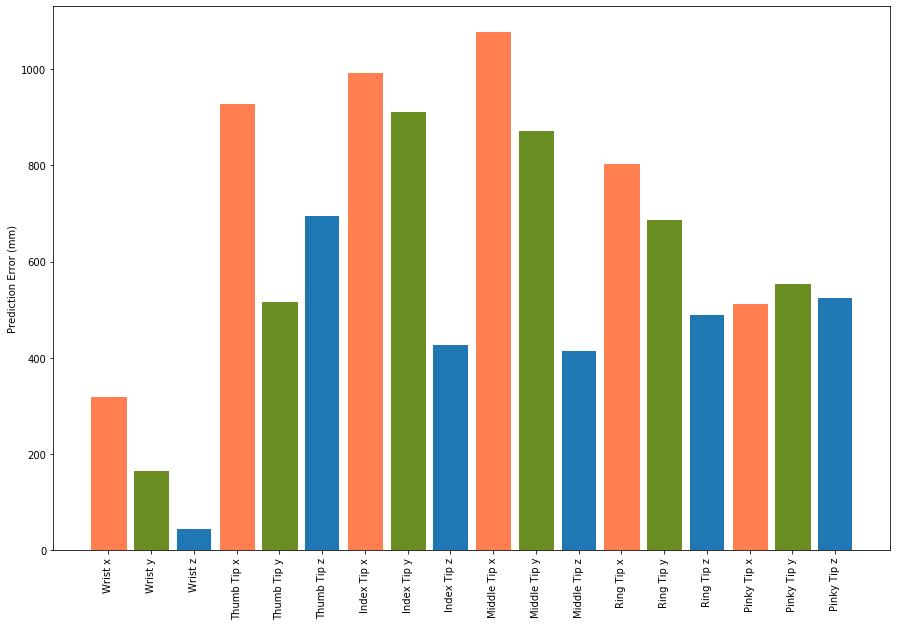

In [55]:
error = labels_tips - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
#bar = plt.bar(df.columns[8:], avg_error)
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()